# Author Statistics
This script will calculate the author insights into the accepted papers based on the data from `./data-proceedings/authors.csv`.

Author: Sven Mayer (info@sven-mayer.com)

LICENSE: GPL-3.0 license 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas
gdf = geopandas.read_file("./utils/ne_10m_admin_0_countries_lakes.shp")[['ADMIN', 'ADM0_A3', 'geometry']]
gdf = gdf.rename(columns = {"ADMIN":"Country", "ADM0_A3":"Alpha-3"})

colors = ["#FF523F","#FFAD33","#198D6D","#6599FF","#683b96","#f07adb"]

In [2]:
df = pd.read_csv("./data-proceedings/authors.csv")

dfAuthor = df.groupby(["Url", "Name"]).Year.count().reset_index()
dfAuthor = dfAuthor.rename(columns={"Year":"PaperCount"})
dfAuthor = dfAuthor.sort_values(by="PaperCount", ascending=False)

if ("PaperCount" in df.columns):
    df = df.drop(columns=["PaperCount"])

df = pd.merge(df, dfAuthor[["Url", "PaperCount"]], on='Url', how='left')

dfCount = df.Doi.value_counts()
dfCount = dfCount.reset_index()
dfCount = dfCount.rename(columns={'count': 'AuthorsOnPaperCount'})

if ("AuthorsOnPaperCount" in df.columns):
    df = df.drop(columns=["AuthorsOnPaperCount"])

df = pd.merge(df, dfCount, left_on='Doi', right_on='Doi', how='left')

df["AuthorContribution"] = 1/df.AuthorsOnPaperCount

dfX = df.groupby("Url").AuthorContribution.sum().reset_index()

dfAuthor = pd.merge(dfAuthor, dfX[["Url", "AuthorContribution"]], on='Url', how='left')

print(len(df))
df.head()

3714


,Year,Doi,Title,Order,Name,Affiliation,Alpha-3,Url,Type,Session,PaperCount,AuthorsOnPaperCount,AuthorContribution
0,2005,10.1145/1085777.1085779,NaN,1,Dan Hong,Hong Kong University of Science and Technology,HKG,https://dl.acm.org/profile/81100648888,ARTICLE,SESSION: Social communication,1.0,3,0.333333
1,2005,10.1145/1085777.1085779,NaN,2,Mingxuan Yuan,Xi'an Jiaotong University,CHN,https://dl.acm.org/profile/81542861056,ARTICLE,SESSION: Social communication,1.0,3,0.333333
2,2005,10.1145/1085777.1085779,NaN,3,Vincent Yun Shen Shen,Hong Kong University of Science and Technology,HKG,https://dl.acm.org/profile/81100343034,ARTICLE,SESSION: Social communication,1.0,3,0.333333
3,2005,10.1145/1085777.1085780,NaN,1,Stavros Antifakos,ETH Zurich,CHE,https://dl.acm.org/profile/81100278693,ARTICLE,SESSION: Social communication,1.0,4,0.250000
4,2005,10.1145/1085777.1085780,NaN,2,Nicky Kern,Technical University of Darmstadt,DEU,https://dl.acm.org/profile/81100599042,ARTICLE,SESSION: Social communication,1.0,4,0.250000


In [3]:
print(f"In total {len(dfAuthor)} unique authors contributed to the conference.")

print(f"Each author contributed on average to {dfAuthor.PaperCount.mean():.2f} papers (SD={dfAuthor.PaperCount.std():.2f}).")

x = dfAuthor[dfAuthor.PaperCount == 1]
print(f"Most authors ({len(x)}) contributed to only one paper ({len(x)/len(dfAuthor)*100:.2f}%).")

x = dfAuthor[dfAuthor.PaperCount > 5]
print(f"Only {len(x)} authors contributed to more than 5 papers ({len(x)/len(dfAuthor)*100:.2f}%).")

dfMoreThan10Papers = dfAuthor[dfAuthor.PaperCount > 10]
print(f"Only {len(dfMoreThan10Papers)} authors contributed to more than 10 papers ({len(dfMoreThan10Papers)/len(dfAuthor)*100:.2f}%).")
for i, e in dfMoreThan10Papers.iterrows():
    print(f"{e.Name}: {e.PaperCount}")

In total 2571 unique authors contributed to the conference.
Each author contributed on average to 1.44 papers (SD=1.45).
Most authors (2072) contributed to only one paper (80.59%).
Only 53 authors contributed to more than 5 papers (2.06%).
Only 14 authors contributed to more than 10 papers (0.54%).
Enrico Rukzio: 25
Stephen Anthony Brewster: 17
Susanne Boll: 16
Niels Henze: 16
Pourang Polad Irani: 16
Jonna Häkkilä: 15
Sven Mayer: 15
Rod Murray-Smith: 14
Albrecht Schmidt: 14
Johannes Schöning: 13
Paweł W. Woźniak: 13
Michael Rohs: 13
Matt Jones: 11
Martin Pielot: 11


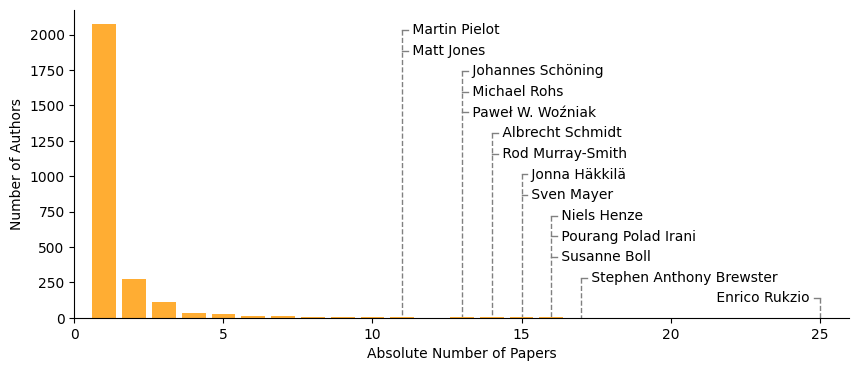

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.hist(dfAuthor.PaperCount, range=(1, dfAuthor.PaperCount.max()+1), bins=dfAuthor.PaperCount.max(), align='left', rwidth=0.8, color=colors[1])

ax.set_ylabel("Number of Authors")
ax.set_xlabel("Absolute Number of Papers")
ax.set_xlim(0, dfAuthor.PaperCount.max()+1)

dfMoreThan15Papers = dfAuthor[dfAuthor.PaperCount > 10]

paddingBottom = 20
paddingTop  = 8
space = dfAuthor.groupby("PaperCount").PaperCount.count().max() - dfMoreThan15Papers.groupby("PaperCount").PaperCount.count().max() - paddingBottom - paddingTop
spacing = space/len(dfMoreThan15Papers)
nameSpacer = dfAuthor.PaperCount.max() * 0.008

lastPaperCount = 0
for i, e in dfMoreThan15Papers.sort_values(["PaperCount", "Name"]).reset_index().iterrows():
    ha = "left"
    if e.PaperCount > 20:
        ha = "right"

    if ha == "left":
        plt.text(e.PaperCount+nameSpacer,space - (i * spacing) - paddingTop, f" {e.Name} ", ha=ha, va='center')
    else:
        plt.text(e.PaperCount-nameSpacer,space - (i * spacing) - paddingTop, f" {e.Name} ", ha=ha, va='center')

    if (lastPaperCount != e.PaperCount):
        plt.plot([e.PaperCount, e.PaperCount], [space - (i * spacing) - paddingTop,0], color='grey', linewidth=1, ls='--', zorder=-99)

    if ha == "left":
        plt.plot([e.PaperCount, e.PaperCount + nameSpacer], [space - (i * spacing) - paddingTop, space - (i * spacing) - paddingTop], color='grey', linewidth=1)
    else:
        plt.plot([e.PaperCount, e.PaperCount - nameSpacer], [space - (i * spacing) - paddingTop, space - (i * spacing) - paddingTop], color='grey', linewidth=1)

    lastPaperCount = e.PaperCount

ax.spines[['right', 'top']].set_visible(False)
plt.savefig("./figures/author_paperCount.jpg", bbox_inches='tight', pad_inches=0, dpi=300, transparent=False)

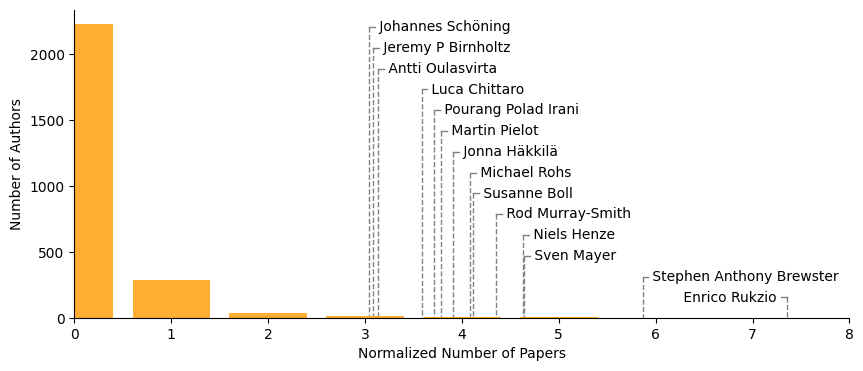

In [5]:
dfAuthor["AuthorContributionBin"] = dfAuthor.AuthorContribution.round()

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.hist(dfAuthor.AuthorContributionBin, range=(0, dfAuthor.AuthorContributionBin.max()+1), bins=int(np.ceil(dfAuthor.AuthorContributionBin.max()))+1, align='left', rwidth=0.8, color=colors[1])

ax.set_ylabel("Number of Authors")
ax.set_xlabel("Normalized Number of Papers")
ax.set_xlim(0, dfAuthor.AuthorContributionBin.max()+1)

dfMoreThan15Papers = dfAuthor[dfAuthor.AuthorContribution > 3]

paddingBottom = 4
paddingTop  = 4
space = dfAuthor.groupby("AuthorContributionBin").AuthorContribution.count().max() - dfMoreThan15Papers.groupby("AuthorContributionBin").AuthorContribution.count().max() - paddingBottom - paddingTop
spacing = space/len(dfMoreThan15Papers)
nameSpacer = dfAuthor.AuthorContribution.max() * 0.008

lastAuthorContribution = 0
for i, e in dfMoreThan15Papers.sort_values(["AuthorContribution", "Name"]).reset_index().iterrows():
    ha = "left"
    if e.AuthorContribution > 6:
        ha = "right"

    if ha == "left":
        plt.text(e.AuthorContribution+nameSpacer,space - (i * spacing) - paddingTop, f" {e.Name} ", ha=ha, va='center')
    else:
        plt.text(e.AuthorContribution-nameSpacer,space - (i * spacing) - paddingTop, f" {e.Name} ", ha=ha, va='center')

    if (lastAuthorContribution != e.AuthorContribution):
        plt.plot([e.AuthorContribution, e.AuthorContribution], [space - (i * spacing) - paddingTop,0], color='grey', linewidth=1, ls='--', zorder=-99)

    if ha == "left":
        plt.plot([e.AuthorContribution, e.AuthorContribution + nameSpacer], [space - (i * spacing) - paddingTop, space - (i * spacing) - paddingTop], color='grey', linewidth=1)
    else:
        plt.plot([e.AuthorContribution, e.AuthorContribution - nameSpacer], [space - (i * spacing) - paddingTop, space - (i * spacing) - paddingTop], color='grey', linewidth=1)

    lastAuthorContribution = e.AuthorContribution

ax.spines[['right', 'top']].set_visible(False)
plt.savefig("./figures/author_AuthorContribution.jpg", bbox_inches='tight', pad_inches=0, dpi=300, transparent=False)

In [6]:
dfTopContributer = dfAuthor[dfAuthor.PaperCount > 10]

print(f"A total of {len(dfTopContributer)} authors have contributed to more than 10 papers each.")
absoluteContributions = df[df.Url.isin(dfTopContributer.Url)].Doi.count()
uniqueContributions = len(df[df.Url.isin(dfTopContributer.Url)].groupby("Doi").count())

print(f"Collectively, their contributions amount to  {absoluteContributions} papers, of which {uniqueContributions} are unique.")
print(f"This indicates that {absoluteContributions - uniqueContributions} papers were co-authored by multiple top contributors.")

countAllPapers = df.Doi.nunique()
print(f"Notably, these {len(dfTopContributer)} leading authors account for {uniqueContributions/countAllPapers*100:.2f}% of all papers published at MobileHCI, underscoring their significant influence on the conference’s research output.")

A total of 14 authors have contributed to more than 10 papers each.
Collectively, their contributions amount to  209 papers, of which 176 are unique.
This indicates that 33 papers were co-authored by multiple top contributors.
Notably, these 14 leading authors account for 18.37% of all papers published at MobileHCI, underscoring their significant influence on the conference’s research output.


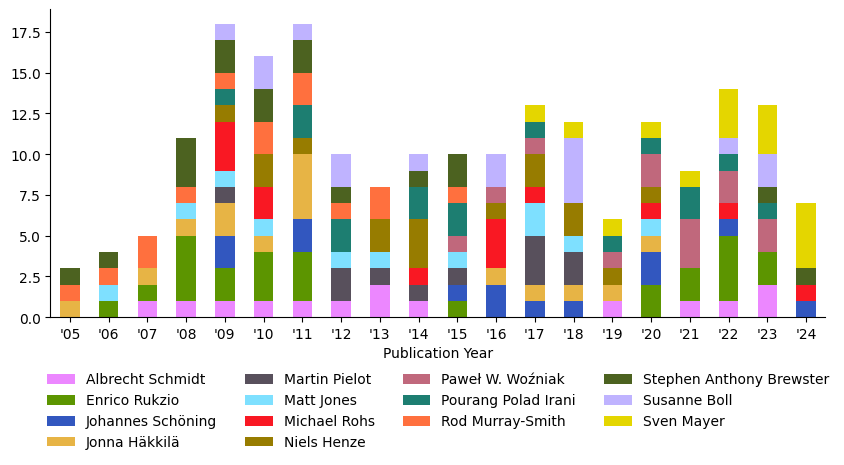

In [7]:
color20 = ["#ec87ff","#5c9500","#3257bf","#e7b445","#58505c","#7ee0ff","#f91823","#977c00","#c0687c","#1d7e71","#ff703e","#4c6220","#bfb3ff","#e4d600","#872198","#c6ff16","#e82cd3","#38ff6d","#99273d","#92a3ab"]

dfX = df[df.Url.isin(dfTopContributer.Url)].groupby(["Year", "Name"]).count().Doi.reset_index()
dfX = dfX.rename(columns={"Doi":"PaperCount"})
dfX = dfX.pivot(index='Year', columns='Name', values='PaperCount')
dfX = dfX[sorted(dfX.columns)]

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
dfX.plot(kind='bar', stacked=True, color=color20, ax=ax)

dfX = dfX.reset_index()
ax.set_xticks(dfX.drop_duplicates("Year").sort_values("Year").Year.values  - dfX.Year.min(), dfX.drop_duplicates("Year").sort_values("Year").Year.apply(lambda x: "'"+str(x)[2:]).values, rotation=0)

ax.set_xlabel("Publication Year")
ax.legend(loc='lower center', frameon=False, ncol=4, bbox_to_anchor=(0.5, -0.47))

ax.spines[['right', 'top']].set_visible(False)
# plt.savefig("./figures/authors_TopContributer.png", bbox_inches='tight', pad_inches=0, dpi=300, transparent=False)
plt.show()


In [8]:
df = df.sort_values("Year")
dfAuthors = df.drop_duplicates(subset=['Url'], keep='last')
dfAuthors = dfAuthors[["Name", "Affiliation", "Year", "AuthorContribution", "Url"]]
dfAuthors = dfAuthors.rename(columns={'Year': 'LastYear'})

In [9]:
from global_gender_predictor import GlobalGenderPredictor
predictor = GlobalGenderPredictor()

dfAuthors["AssumedGender"] = dfAuthors.Name.apply(lambda x: predictor.predict_gender(x.split(" ")[0]))
df["AssumedGender"] = df.Name.apply(lambda x: predictor.predict_gender(x.split(" ")[0]))

dfAuthors.AssumedGender.value_counts()

# Alternative predictor
if False:
    import gender_guesser.detector
    d = gender_guesser.detector.Detector()

    dfAuthors["AssumedGender"] = dfAuthors.Name.apply(lambda x: d.get_gender(x.split(" ")[0]))
    df["AssumedGender"] = df.Name.apply(lambda x: d.get_gender(x.split(" ")[0]))

    df.loc[df.AssumedGender == "andy", "AssumedGender"] = "both"
    dfAuthors.loc[dfAuthors.AssumedGender == "andy", "AssumedGender"] = "both"
    dfAuthors.AssumedGender.value_counts()


Female Ratio Trendline fit: 0.0018x + 22.348
Unknown Trendline fit: -0.5435x + 94.158


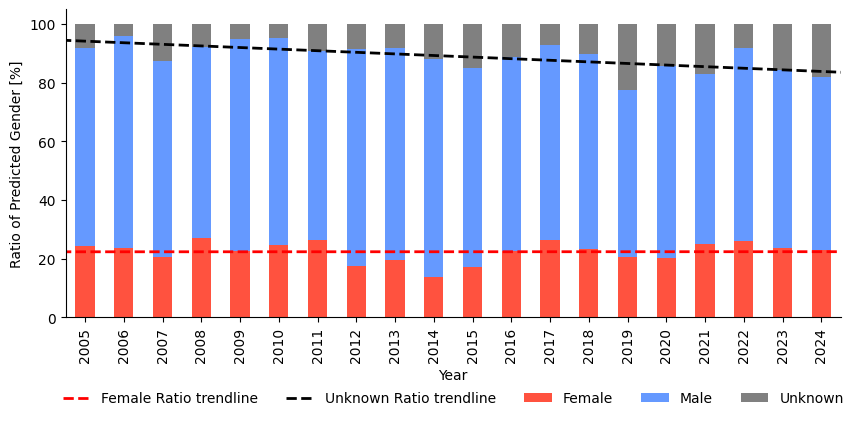

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

dfX = df.groupby("Year").AssumedGender.value_counts().unstack()
dfX = dfX.fillna(0)
dfX["Sum"] = dfX.sum(axis=1)
for c in dfX.columns:
    dfX[c] = dfX[c] / dfX["Sum"] * 100

del dfX["Sum"]

dfX.plot(kind='bar', stacked=True, color=[colors[0], colors[3],  "gray"], ax=ax)

# Fit linear line
x = range(0, len(dfX.Female.values))
m, b = np.polyfit(x, dfX.Female.values, 1)
print(f"Female Ratio Trendline fit: {m:.4f}x + {b:.3f}")
x = range(-1, len(x)+1)
plt.plot(x, m*x+b, color="r", linewidth=2, ls="--", label="Female Ratio trendline")

x = range(0, len(dfX.Female.values))
m, b = np.polyfit(x, dfX.Female.values + dfX.Male.values, 1)
x = range(-1, len(x)+1)
print(f"Unknown Trendline fit: {m:.4f}x + {b:.3f}")
plt.plot(x, m*x+b, color="k", linewidth=2, ls="--", label="Unknown Ratio trendline")


ax.set_ylabel("Ratio of Predicted Gender [%]")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=6, frameon=False)


ax.spines[['right', 'top']].set_visible(False)
plt.savefig("./figures/author_Gender.jpg", bbox_inches='tight', pad_inches=0, dpi=300, transparent=False)

In [11]:
# Simple check of as "unknown" predicted first names
dfX = df[df.AssumedGender == "Unknown"].Name.apply(lambda x: x.split(" ")[0]).value_counts()
dfX = dfX.reset_index()
dfX[dfX["count"] > 2]

,Name,count
0,Pourang,16
1,Yungju,7
2,Wei,7
3,Geehyuk,6
4,Bing-Yu,5
5,Nicola,4
6,Jie,4
7,Tanzeem,3
8,Sunjun,3
9,Shumin,3


In [12]:
dfExport = dfAuthor[['Name', 'Url', 'PaperCount', 'AuthorContribution']]
dfExport = dfExport.sort_values(by="PaperCount", ascending=False)
dfExport.to_csv("./export/authors.csv", index=False)